<a href="https://colab.research.google.com/github/b-erke/H-M-Recommendation-System/blob/main/CNN_Model_State_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
# Reshape data to fit the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [5]:
# Convert labels to one-hot encoding
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

In [6]:
# Create anomalous data
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

In [21]:
# Add different types of noise to some of the train and test images
noisy_train_images_type1 = add_noise(train_images[6000:6250], noise_factor=0.1)
noisy_train_images_type2 = add_noise(train_images[6250:6500], noise_factor=0.2)
noisy_train_images_type3 = add_noise(train_images[6500:6750], noise_factor=0.3)
noisy_train_images_type4 = add_noise(train_images[6750:7000], noise_factor=0.4)

noisy_test_images_type1 = add_noise(test_images[1000:1050], noise_factor=0.1)
noisy_test_images_type2 = add_noise(test_images[1050:1100], noise_factor=0.2)
noisy_test_images_type3 = add_noise(test_images[1100:1150], noise_factor=0.3)
noisy_test_images_type4 = add_noise(test_images[1150:1200], noise_factor=0.4)

In [22]:
# Combine normal and noisy data
combined_train_images = np.concatenate((train_images[:6000],
                                        noisy_train_images_type1, noisy_train_images_type2,
                                        noisy_train_images_type3, noisy_train_images_type4), axis=0)

combined_train_labels = np.concatenate((train_labels_cat[:6000],
                                        train_labels_cat[6000:6250], train_labels_cat[6250:6500],
                                        train_labels_cat[6500:6750], train_labels_cat[6750:7000]), axis=0)

combined_test_images = np.concatenate((test_images[:1000],
                                       noisy_test_images_type1, noisy_test_images_type2,
                                       noisy_test_images_type3, noisy_test_images_type4), axis=0)

combined_test_labels = np.concatenate((test_labels_cat[:1000],
                                       test_labels_cat[1000:1050], test_labels_cat[1050:1100],
                                       test_labels_cat[1100:1150], test_labels_cat[1150:1200]), axis=0)


In [23]:
# Build the ANN model
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(10, activation='softmax')(x)

In [24]:
model = Model(inputs=input_layer, outputs=output_layer)

In [25]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Train the model
model.fit(combined_train_images, combined_train_labels, epochs=8, validation_data=(combined_test_images, combined_test_labels))

Epoch 1/8
219/219 [==============================] - 6s 23ms/step - loss: 0.7470 - accuracy: 0.7659 - val_loss: 0.3880 - val_accuracy: 0.8850
Epoch 2/8
219/219 [==============================] - 6s 28ms/step - loss: 0.3394 - accuracy: 0.8959 - val_loss: 0.2526 - val_accuracy: 0.9208
Epoch 3/8
219/219 [==============================] - 5s 24ms/step - loss: 0.2529 - accuracy: 0.9250 - val_loss: 0.2061 - val_accuracy: 0.9342
Epoch 4/8
219/219 [==============================] - 5s 22ms/step - loss: 0.1893 - accuracy: 0.9460 - val_loss: 0.1790 - val_accuracy: 0.9425
Epoch 5/8
219/219 [==============================] - 6s 29ms/step - loss: 0.1576 - accuracy: 0.9539 - val_loss: 0.1549 - val_accuracy: 0.9483
Epoch 6/8
219/219 [==============================] - 5s 22ms/step - loss: 0.1386 - accuracy: 0.9597 - val_loss: 0.1353 - val_accuracy: 0.9533
Epoch 7/8
219/219 [==============================] - 6s 28ms/step - loss: 0.1185 - accuracy: 0.9631 - val_loss: 0.1273 - val_accuracy: 0.9558
Epoch 

In [27]:
# Extract model-state data from specific layers
layer_names = list(map(lambda x: x.name, model.layers))
print("Layer names:", layer_names)

Layer names: ['input_2', 'conv2d_1', 'max_pooling2d_1', 'dropout_2', 'flatten_1', 'dense_2', 'dropout_3', 'dense_3']


In [29]:
intermediate_layer_model1 = Model(inputs=model.input, outputs=model.get_layer("dense_2").output)
intermediate_layer_model2 = Model(inputs=model.input, outputs=model.get_layer("dense_3").output)

In [30]:
# Get model-state data
model_state_data_layer1 = intermediate_layer_model1.predict(combined_train_images)
model_state_data_layer2 = intermediate_layer_model2.predict(combined_train_images)

219/219 [==============================] - 2s 9ms/step


In [31]:
# Save model-state data to CSV files
pd.DataFrame(model_state_data_layer1).to_csv("first_layer_dense.csv", index=False, header=False)
pd.DataFrame(model_state_data_layer2).to_csv("second_layer_dense.csv", index=False, header=False)

In [32]:
# Load model-state data from CSV files and display
model_state_data_layer1 = pd.read_csv("first_layer_dense.csv", header=None)
model_state_data_layer2 = pd.read_csv("second_layer_dense.csv", header=None)

In [33]:
print("Model-state data (First layer):")
print(model_state_data_layer1.head(4))
print("Model-state data (Second layer):")
print(model_state_data_layer2.head(4))

Model-state data (First layer):
   0    1         2         3         4         5         6    7        8    \
0  0.0  0.0  0.000000  4.426269  0.530099  0.000000  0.000000  0.0  0.00000   
1  0.0  0.0  3.679674  1.234582  1.497945  0.000000  2.337477  0.0  1.54106   
2  0.0  0.0  0.000000  0.000000  0.000000  3.949250  0.285628  0.0  0.00000   
3  0.0  0.0  1.919407  0.585992  0.000000  3.428656  1.873892  0.0  0.00000   

        9    ...       118  119       120       121       122       123  \
0  0.000000  ...  0.830694  0.0  0.000000  0.000000  0.575078  4.905731   
1  3.378183  ...  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
2  1.889739  ...  1.043593  0.0  3.921444  3.054632  0.000000  0.000000   
3  0.000000  ...  0.000000  0.0  0.000000  2.176185  0.000000  0.000000   

        124       125       126  127  
0  0.000000  0.461122  3.452964  0.0  
1  0.000000  0.000000  3.445768  0.0  
2  2.964647  0.731088  0.000000  0.0  
3  0.000000  1.966934  0.000000  0.0  



In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [35]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

In [36]:
# Traditional approach using raw pixel data
model.fit(train_images, train_labels_cat, epochs=8, validation_data=(test_images, test_labels_cat))


Epoch 1/8
1875/1875 [==============================] - 66s 35ms/step - loss: 0.1357 - accuracy: 0.9598 - val_loss: 0.0594 - val_accuracy: 0.9813
Epoch 2/8
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0946 - accuracy: 0.9709 - val_loss: 0.0437 - val_accuracy: 0.9856
Epoch 3/8
1875/1875 [==============================] - 80s 42ms/step - loss: 0.0769 - accuracy: 0.9769 - val_loss: 0.0366 - val_accuracy: 0.9885
Epoch 4/8
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0654 - accuracy: 0.9792 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 5/8
1875/1875 [==============================] - 48s 26ms/step - loss: 0.0555 - accuracy: 0.9819 - val_loss: 0.0374 - val_accuracy: 0.9881
Epoch 6/8
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0531 - accuracy: 0.9836 - val_loss: 0.0396 - val_accuracy: 0.9872
Epoch 7/8
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0385 - val_ac

In [37]:
# Make predictions
y_pred_test_pixel = model.predict(test_images)
y_pred_test_pixel = np.argmax(y_pred_test_pixel, axis=1)

313/313 [==============================] - 2s 6ms/step


In [38]:
# Evaluate traditional approach
precision_pixel, recall_pixel, f1_pixel = evaluate_model(test_labels, y_pred_test_pixel)

In [39]:
print(f"Traditional Approach - Precision: {precision_pixel}, Recall: {recall_pixel}, F1-Score: {f1_pixel}")

# Novel approach using model-state data
# Assume 'model_state_data_layer1' and 'model_state_data_layer2' are already extracted
# Train a simple classifier on model-state data (for example, logistic regression)


Traditional Approach - Precision: 0.9884083666115465, Recall: 0.9884006849903146, F1-Score: 0.9883840334301958


In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [44]:
# Define ANN classifier for model-state data
def build_ann_classifier(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [45]:
# Convert labels back to original form for training the classifier
combined_train_labels_original = np.argmax(combined_train_labels, axis=1)
combined_test_labels_original = np.argmax(combined_test_labels, axis=1)

In [46]:
# Train ANN classifier on model-state data of the first layer
ann_classifier_layer1 = build_ann_classifier((model_state_data_layer1.shape[1],))
ann_classifier_layer1.fit(model_state_data_layer1, combined_train_labels_original, epochs=8, validation_data=(model_state_data_layer1, combined_train_labels_original))

Epoch 1/8
219/219 [==============================] - 2s 4ms/step - loss: 0.3634 - accuracy: 0.9141 - val_loss: 0.0517 - val_accuracy: 0.9897
Epoch 2/8
219/219 [==============================] - 1s 4ms/step - loss: 0.0413 - accuracy: 0.9899 - val_loss: 0.0298 - val_accuracy: 0.9927
Epoch 3/8
219/219 [==============================] - 1s 4ms/step - loss: 0.0288 - accuracy: 0.9921 - val_loss: 0.0212 - val_accuracy: 0.9940
Epoch 4/8
219/219 [==============================] - 1s 4ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0165 - val_accuracy: 0.9961
Epoch 5/8
219/219 [==============================] - 1s 6ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0130 - val_accuracy: 0.9966
Epoch 6/8
219/219 [==============================] - 1s 7ms/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.0107 - val_accuracy: 0.9973
Epoch 7/8
219/219 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.0105 - val_accuracy: 0.9976
Epoch 8/8
219

In [47]:
# Evaluate on test set
model_state_data_test_layer1 = intermediate_layer_model1.predict(combined_test_images)
y_pred_test_layer1 = ann_classifier_layer1.predict(model_state_data_test_layer1)
y_pred_test_layer1 = np.argmax(y_pred_test_layer1, axis=1)

38/38 [==============================] - 0s 1ms/step


In [48]:
# Calculate evaluation metrics for the novel approach
precision_layer1, recall_layer1, f1_layer1 = evaluate_model(combined_test_labels_original, y_pred_test_layer1)


In [49]:
print(f"Novel Approach (First Layer) - Precision: {precision_layer1}, Recall: {recall_layer1}, F1-Score: {f1_layer1}")

Novel Approach (First Layer) - Precision: 0.9605578872616343, Recall: 0.9573721024371219, F1-Score: 0.9583306133508254


In [50]:
# Train ANN classifier on model-state data of the second layer
ann_classifier_layer2 = build_ann_classifier((model_state_data_layer2.shape[1],))
ann_classifier_layer2.fit(model_state_data_layer2, combined_train_labels_original, epochs=8, validation_data=(model_state_data_layer2, combined_train_labels_original))

Epoch 1/8
219/219 [==============================] - 2s 4ms/step - loss: 0.9628 - accuracy: 0.8891 - val_loss: 0.0809 - val_accuracy: 0.9933
Epoch 2/8
219/219 [==============================] - 2s 7ms/step - loss: 0.0488 - accuracy: 0.9934 - val_loss: 0.0368 - val_accuracy: 0.9931
Epoch 3/8
219/219 [==============================] - 2s 9ms/step - loss: 0.0349 - accuracy: 0.9931 - val_loss: 0.0330 - val_accuracy: 0.9933
Epoch 4/8
219/219 [==============================] - 2s 8ms/step - loss: 0.0325 - accuracy: 0.9934 - val_loss: 0.0300 - val_accuracy: 0.9936
Epoch 5/8
219/219 [==============================] - 2s 10ms/step - loss: 0.0315 - accuracy: 0.9936 - val_loss: 0.0291 - val_accuracy: 0.9937
Epoch 6/8
219/219 [==============================] - 1s 5ms/step - loss: 0.0304 - accuracy: 0.9934 - val_loss: 0.0283 - val_accuracy: 0.9936
Epoch 7/8
219/219 [==============================] - 1s 6ms/step - loss: 0.0295 - accuracy: 0.9937 - val_loss: 0.0277 - val_accuracy: 0.9937
Epoch 8/8
21

In [51]:
# Evaluate on test set
model_state_data_test_layer2 = intermediate_layer_model2.predict(combined_test_images)
y_pred_test_layer2 = ann_classifier_layer2.predict(model_state_data_test_layer2)
y_pred_test_layer2 = np.argmax(y_pred_test_layer2, axis=1)

38/38 [==============================] - 0s 1ms/step


In [52]:
precision_layer2, recall_layer2, f1_layer2 = evaluate_model(combined_test_labels_original, y_pred_test_layer2)

In [53]:
print(f"Novel Approach (Second Layer) - Precision: {precision_layer2}, Recall: {recall_layer2}, F1-Score: {f1_layer2}")

Novel Approach (Second Layer) - Precision: 0.9710350021334506, Recall: 0.9677240544922648, F1-Score: 0.9689516363204562


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Generate confusion matrices for each type of noise and layer
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

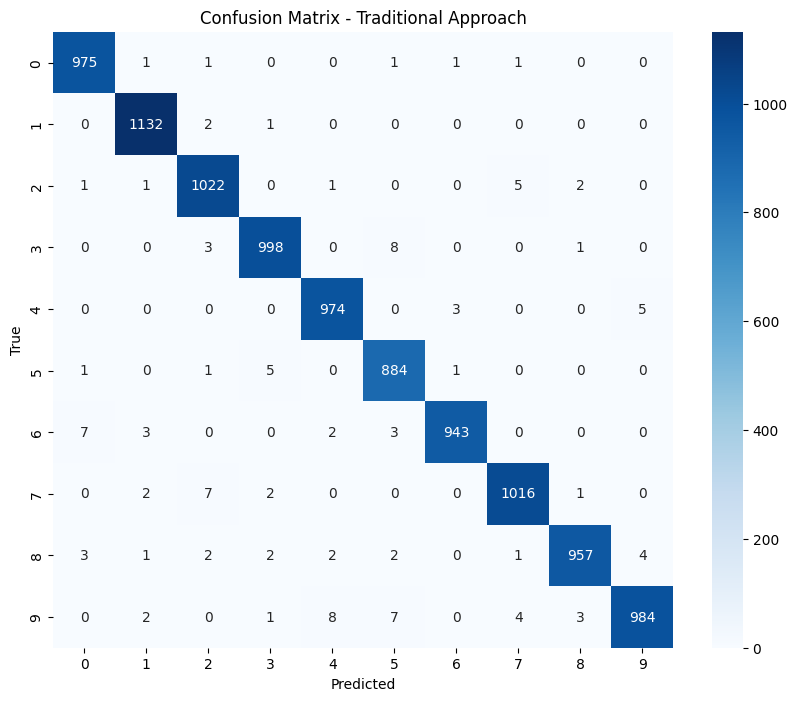

In [60]:
# Plot confusion matrices for the traditional approach
plot_confusion_matrix(test_labels, y_pred_test_pixel, "Confusion Matrix - Traditional Approach")

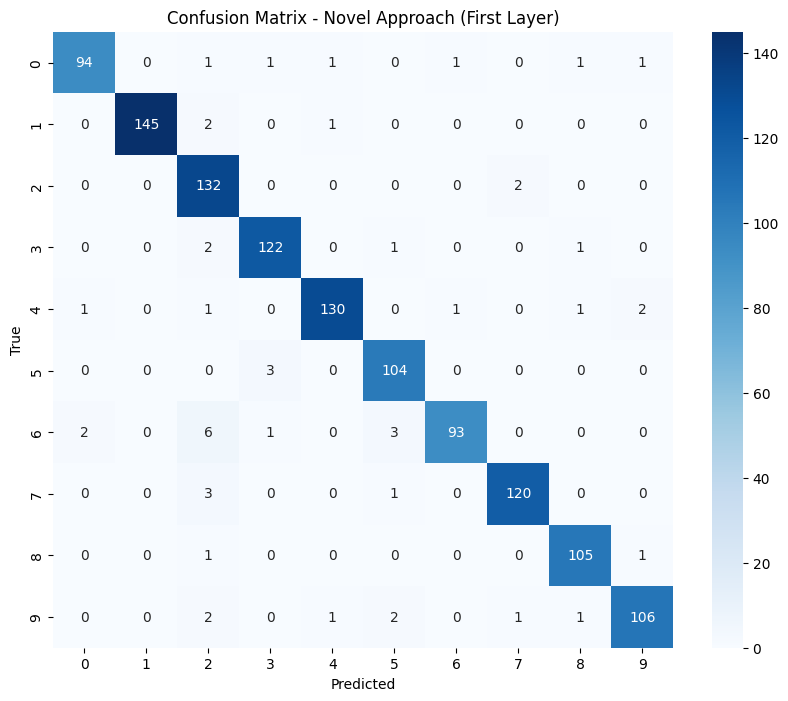

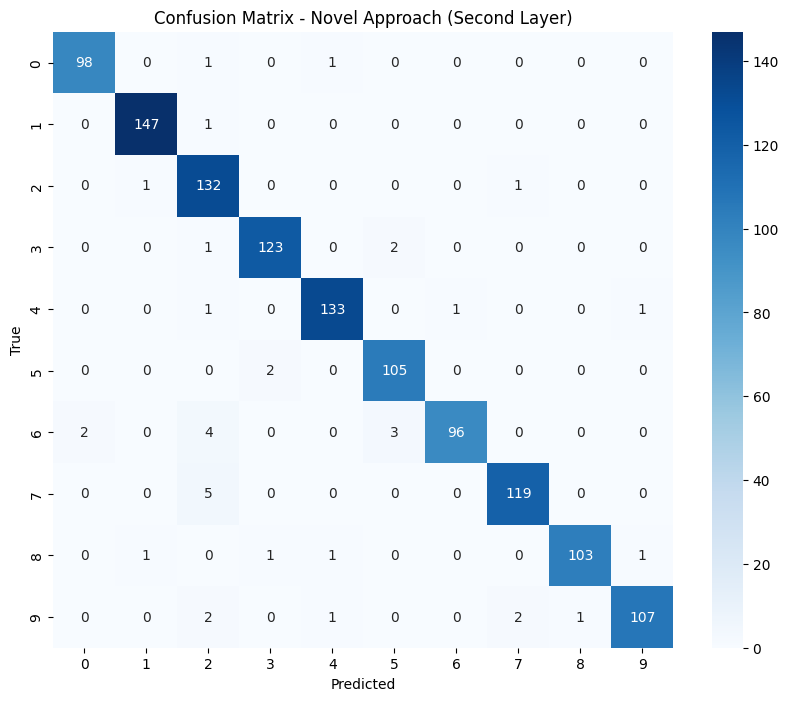

In [61]:
# Plot confusion matrices for the novel approach using model-state data
plot_confusion_matrix(combined_test_labels_original, y_pred_test_layer1, "Confusion Matrix - Novel Approach (First Layer)")
plot_confusion_matrix(combined_test_labels_original, y_pred_test_layer2, "Confusion Matrix - Novel Approach (Second Layer)")

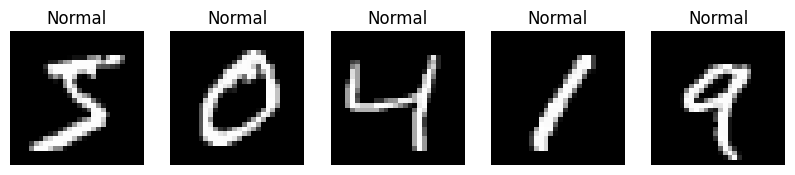

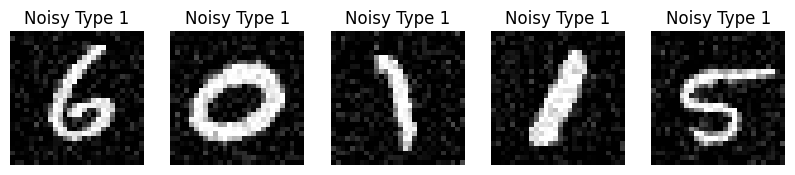

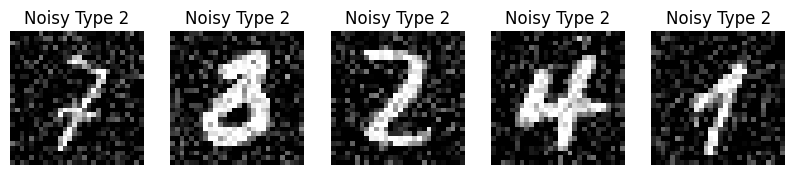

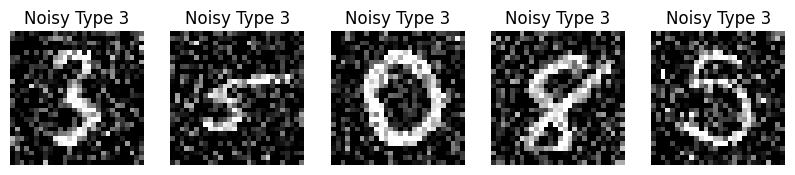

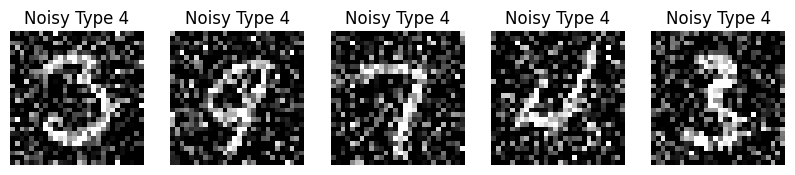

In [70]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, titles, n_cols=5):
    n_rows = (len(images) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Select examples to visualize
normal_examples = train_images[:5]  # First 5 normal images
noisy_examples_type1 = noisy_train_images_type1[:5]  # First 5 type 1 noisy images
noisy_examples_type2 = noisy_train_images_type2[:5]  # First 5 type 2 noisy images
noisy_examples_type3 = noisy_train_images_type3[:5]  # First 5 type 3 noisy images
noisy_examples_type4 = noisy_train_images_type4[:5]  # First 5 type 4 noisy images

# Plot normal images
plot_images(normal_examples, ['Normal'] * 5)

# Plot noisy images of type 1
plot_images(noisy_examples_type1, ['Noisy Type 1'] * 5)

# Plot noisy images of type 2
plot_images(noisy_examples_type2, ['Noisy Type 2'] * 5)

# Plot noisy images of type 3
plot_images(noisy_examples_type3, ['Noisy Type 3'] * 5)

# Plot noisy images of type 4
plot_images(noisy_examples_type4, ['Noisy Type 4'] * 5)


In [73]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape data to fit the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [74]:
# Create anomalous data
def add_noise(images, noise_factor):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

# Add different types of noise to some of the train and test images
noisy_train_images_type1 = add_noise(train_images[6000:6250], noise_factor=0.1)
noisy_train_images_type2 = add_noise(train_images[6250:6500], noise_factor=0.2)
noisy_train_images_type3 = add_noise(train_images[6500:6750], noise_factor=0.3)
noisy_train_images_type4 = add_noise(train_images[6750:7000], noise_factor=0.4)

noisy_test_images_type1 = add_noise(test_images[1000:1050], noise_factor=0.1)
noisy_test_images_type2 = add_noise(test_images[1050:1100], noise_factor=0.2)
noisy_test_images_type3 = add_noise(test_images[1100:1150], noise_factor=0.3)
noisy_test_images_type4 = add_noise(test_images[1150:1200], noise_factor=0.4)

In [75]:
# Combine normal and noisy data
combined_train_images = np.concatenate((train_images[:6000],
                                        noisy_train_images_type1, noisy_train_images_type2,
                                        noisy_train_images_type3, noisy_train_images_type4), axis=0)

combined_train_labels = np.concatenate((np.zeros(6000),
                                        np.ones(250), np.full(250, 2),
                                        np.full(250, 3), np.full(250, 4)), axis=0)

combined_test_images = np.concatenate((test_images[:1000],
                                       noisy_test_images_type1, noisy_test_images_type2,
                                       noisy_test_images_type3, noisy_test_images_type4), axis=0)

combined_test_labels = np.concatenate((np.zeros(1000),
                                       np.ones(50), np.full(50, 2),
                                       np.full(50, 3), np.full(50, 4)), axis=0)

In [76]:
# Build the primary ANN model
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation='softmax')(x)  # For multi-class classification (5 classes)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the primary model
model.fit(combined_train_images, combined_train_labels, epochs=8, validation_data=(combined_test_images, combined_test_labels))


Epoch 1/8
219/219 [==============================] - 13s 43ms/step - loss: 0.2574 - accuracy: 0.9011 - val_loss: 0.1332 - val_accuracy: 0.9500
Epoch 2/8
219/219 [==============================] - 13s 57ms/step - loss: 0.1061 - accuracy: 0.9551 - val_loss: 0.0724 - val_accuracy: 0.9908
Epoch 3/8
219/219 [==============================] - 12s 54ms/step - loss: 0.0775 - accuracy: 0.9703 - val_loss: 0.0486 - val_accuracy: 0.9908
Epoch 4/8
219/219 [==============================] - 8s 34ms/step - loss: 0.0604 - accuracy: 0.9771 - val_loss: 0.0283 - val_accuracy: 0.9967
Epoch 5/8
219/219 [==============================] - 9s 42ms/step - loss: 0.0522 - accuracy: 0.9806 - val_loss: 0.0479 - val_accuracy: 0.9850
Epoch 6/8
219/219 [==============================] - 10s 44ms/step - loss: 0.0459 - accuracy: 0.9829 - val_loss: 0.0190 - val_accuracy: 0.9975
Epoch 7/8
219/219 [==============================] - 11s 48ms/step - loss: 0.0411 - accuracy: 0.9834 - val_loss: 0.0158 - val_accuracy: 0.9992
E

In [78]:
# Extract model-state data from specific layers
intermediate_layer_model1 = Model(inputs=model.input, outputs=model.get_layer("dense_19").output)
intermediate_layer_model2 = Model(inputs=model.input, outputs=model.get_layer("dense_20").output)

# Get model-state data
model_state_data_layer1 = intermediate_layer_model1.predict(combined_train_images)
model_state_data_layer2 = intermediate_layer_model2.predict(combined_train_images)

# Save model-state data to CSV files
pd.DataFrame(model_state_data_layer1).to_csv("first_layer_dense.csv", index=False, header=False)
pd.DataFrame(model_state_data_layer2).to_csv("second_layer_dense.csv", index=False, header=False)

219/219 [==============================] - 2s 9ms/step


In [79]:
# Load model-state data from CSV files
model_state_data_layer1 = pd.read_csv("first_layer_dense.csv", header=None)
model_state_data_layer2 = pd.read_csv("second_layer_dense.csv", header=None)

In [80]:
# Define ANN classifier for model-state data
def build_ann_classifier(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))  # For multi-class classification (5 classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Split model-state data into training and validation sets
X_train_layer1, X_val_layer1, y_train_layer1, y_val_layer1 = train_test_split(model_state_data_layer1, combined_train_labels, test_size=0.2, random_state=42)
X_train_layer2, X_val_layer2, y_train_layer2, y_val_layer2 = train_test_split(model_state_data_layer2, combined_train_labels, test_size=0.2, random_state=42)

# Train ANN classifier on model-state data of the first layer
ann_classifier_layer1 = build_ann_classifier((model_state_data_layer1.shape[1],))
ann_classifier_layer1.fit(X_train_layer1, y_train_layer1, epochs=8, validation_data=(X_val_layer1, y_val_layer1))

# Evaluate on test set
model_state_data_test_layer1 = intermediate_layer_model1.predict(combined_test_images)
y_pred_test_layer1 = np.argmax(ann_classifier_layer1.predict(model_state_data_test_layer1), axis=1)


Epoch 1/8
175/175 [==============================] - 2s 5ms/step - loss: 0.1645 - accuracy: 0.9484 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 2/8
175/175 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/8
175/175 [==============================] - 0s 2ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/8
175/175 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 9.7958e-04 - val_accuracy: 1.0000
Epoch 5/8
175/175 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 6.5875e-04 - val_accuracy: 1.0000
Epoch 6/8
175/175 [==============================] - 1s 3ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 5.9249e-04 - val_accuracy: 1.0000
Epoch 7/8
175/175 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
E

In [81]:
# Train ANN classifier on model-state data of the second layer
ann_classifier_layer2 = build_ann_classifier((model_state_data_layer2.shape[1],))
ann_classifier_layer2.fit(X_train_layer2, y_train_layer2, epochs=8, validation_data=(X_val_layer2, y_val_layer2))

# Evaluate on test set
model_state_data_test_layer2 = intermediate_layer_model2.predict(combined_test_images)
y_pred_test_layer2 = np.argmax(ann_classifier_layer2.predict(model_state_data_test_layer2), axis=1)


Epoch 1/8
175/175 [==============================] - 1s 3ms/step - loss: 0.4802 - accuracy: 0.9655 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 2/8
175/175 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.9998 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 3/8
175/175 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/8
175/175 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 9.1368e-04 - val_accuracy: 1.0000
Epoch 5/8
175/175 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 5.9760e-04 - val_accuracy: 1.0000
Epoch 6/8
175/175 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 4.0812e-04 - val_accuracy: 1.0000
Epoch 7/8
175/175 [==============================] - 0s 2ms/step - loss: 9.6811e-04 - accuracy: 0.9996 - val_loss: 3.0287e-04 - val_accuracy: 

In [82]:
# Traditional approach using raw pixel data
model_binary = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # For multi-class classification (5 classes)
])

model_binary.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the multi-class model on pixel data
model_binary.fit(combined_train_images, combined_train_labels, epochs=8, validation_data=(combined_test_images, combined_test_labels))

# Make predictions
y_pred_test_pixel = np.argmax(model_binary.predict(combined_test_images), axis=1)

Epoch 1/8
219/219 [==============================] - 3s 9ms/step - loss: 0.3366 - accuracy: 0.8911 - val_loss: 0.1969 - val_accuracy: 0.9158
Epoch 2/8
219/219 [==============================] - 1s 4ms/step - loss: 0.1565 - accuracy: 0.9336 - val_loss: 0.1517 - val_accuracy: 0.9308
Epoch 3/8
219/219 [==============================] - 1s 4ms/step - loss: 0.1155 - accuracy: 0.9524 - val_loss: 0.1291 - val_accuracy: 0.9433
Epoch 4/8
219/219 [==============================] - 1s 4ms/step - loss: 0.0897 - accuracy: 0.9654 - val_loss: 0.1156 - val_accuracy: 0.9475
Epoch 5/8
219/219 [==============================] - 1s 4ms/step - loss: 0.0739 - accuracy: 0.9736 - val_loss: 0.1104 - val_accuracy: 0.9500
Epoch 6/8
219/219 [==============================] - 1s 4ms/step - loss: 0.0668 - accuracy: 0.9749 - val_loss: 0.1068 - val_accuracy: 0.9467
Epoch 7/8
219/219 [==============================] - 1s 5ms/step - loss: 0.0563 - accuracy: 0.9801 - val_loss: 0.1051 - val_accuracy: 0.9525
Epoch 8/8
38/

In [83]:
# Evaluation metrics
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

In [84]:
# Evaluate and print metrics for the traditional approach
precision_pixel, recall_pixel, f1_pixel = evaluate_model(combined_test_labels, y_pred_test_pixel)
print(f"Traditional Approach - Precision: {precision_pixel}, Recall: {recall_pixel}, F1-Score: {f1_pixel}")

Traditional Approach - Precision: 0.7535681369321923, Recall: 0.756, F1-Score: 0.7514862914862914


In [89]:
# Evaluate and print metrics for the novel approach using model-state data
precision_layer1, recall_layer1, f1_layer1 = evaluate_model(combined_test_labels, y_pred_test_layer1)
print(f"Novel Approach (First Layer) - Precision: {precision_layer1}, Recall: {recall_layer1}, F1-Score: {f1_layer1}")
precision_layer2, recall_layer2, f1_layer2 = evaluate_model(combined_test_labels, y_pred_test_layer2)
print(f"Novel Approach (Second Layer) - Precision: {precision_layer2}, Recall: {recall_layer2}, F1-Score: {f1_layer2}")


Novel Approach (First Layer) - Precision: 0.988078431372549, Recall: 0.9879999999999999, F1-Score: 0.987999599959996
Novel Approach (Second Layer) - Precision: 0.996078431372549, Recall: 0.9960000000000001, F1-Score: 0.9959995999599961


In [90]:
# Generate confusion matrices for each type of approach and layer
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt

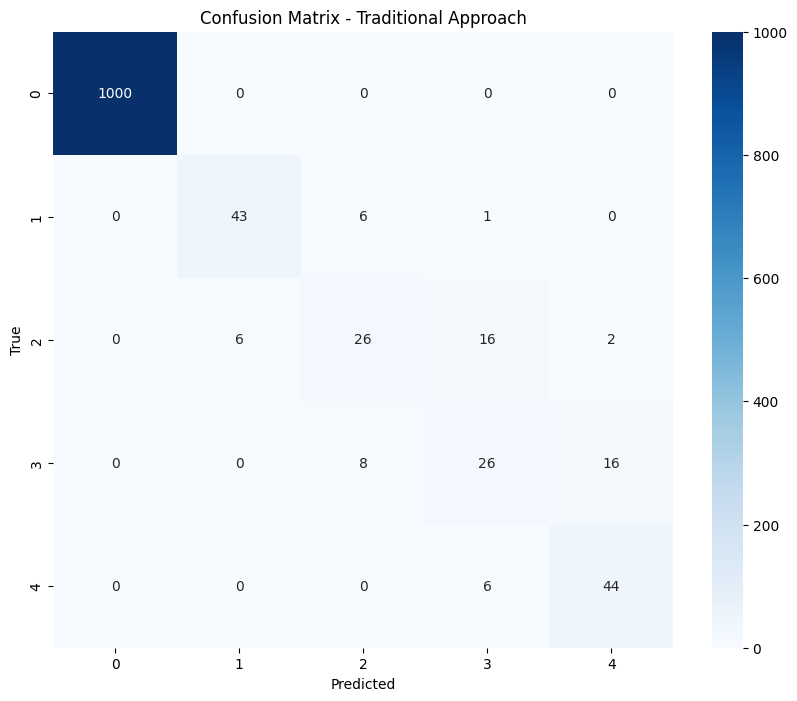

In [91]:
# Plot confusion matrices for the traditional approach
plot_confusion_matrix(combined_test_labels, y_pred_test_pixel, "Confusion Matrix - Traditional Approach")

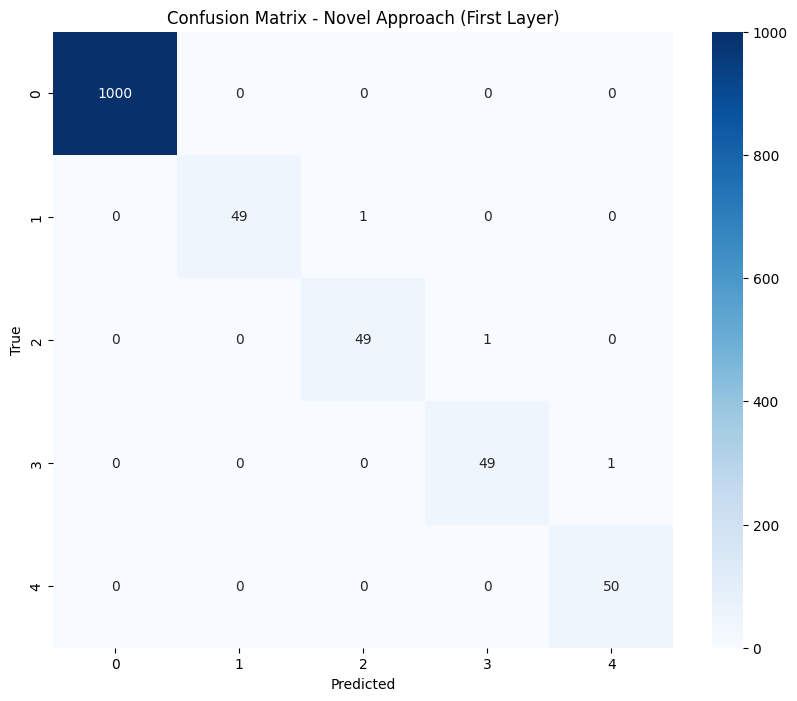

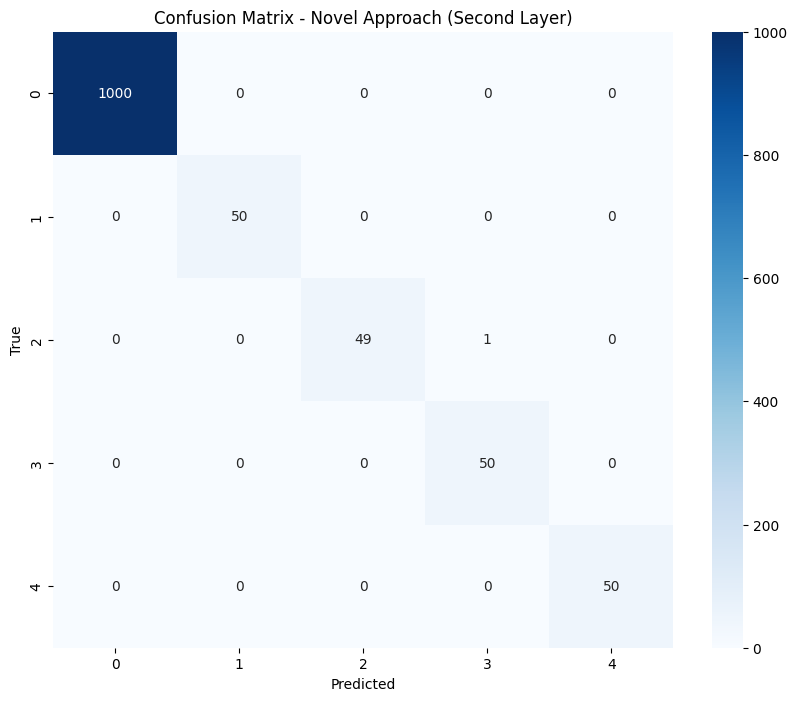

In [93]:
# Plot confusion matrices for the novel approach using model-state data
plot_confusion_matrix(combined_test_labels, y_pred_test_layer1, "Confusion Matrix - Novel Approach (First Layer)")
plot_confusion_matrix(combined_test_labels, y_pred_test_layer2, "Confusion Matrix - Novel Approach (Second Layer)")